In [149]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt

In [150]:
HOST = 'localhost'
PORT = 27017
client = MongoClient(HOST, PORT)

In [151]:
db = client['historical_weather']
capitals = db['capitals']
city = 'Kiev'

In [152]:
cursor = capitals.find({'city_name': city})

In [153]:
df = pd.json_normalize(list(cursor))

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   _id                           124 non-null    object        
 1   city_name                     124 non-null    object        
 2   city_url                      124 non-null    object        
 3   monthly_url                   124 non-null    object        
 4   date                          124 non-null    datetime64[ns]
 5   like                          110 non-null    object        
 6   history.temperature.max       124 non-null    float64       
 7   history.temperature.avg       124 non-null    float64       
 8   history.temperature.min       124 non-null    float64       
 9   history.dew_point.max         124 non-null    float64       
 10  history.dew_point.avg         124 non-null    float64       
 11  history.dew_point.min         12

In [155]:
season_months = {12: 'winter', 1: 'winter', 2: 'winter',
           3: 'spring', 4: 'spring', 5: 'spring',
           6: 'summer', 7: 'summer', 8: 'summer', 
           9: 'autumn', 10: 'autumn', 11: 'autumn'}

df['season'] = df['date'].map(lambda row: season_months[row.month])

In [156]:
options = ['history.humidity.avg', 'history.temperature.avg', 'history.wind_speed.avg']

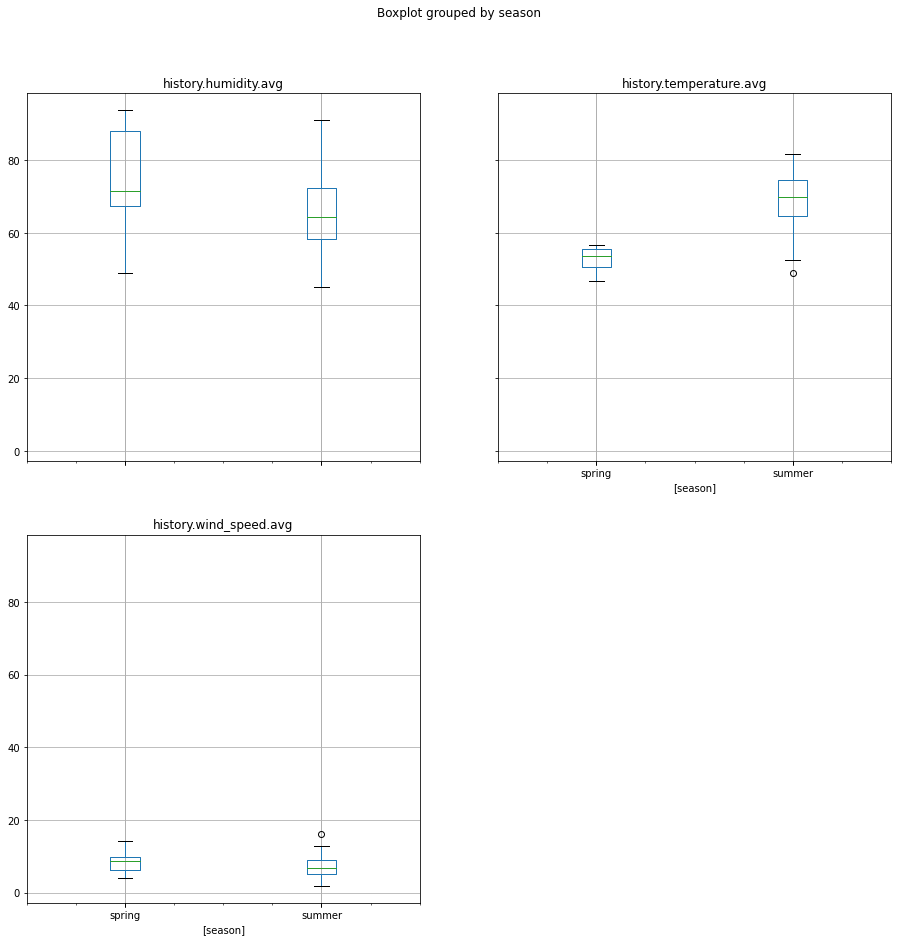

In [157]:
s = df[['season',*options]].boxplot(by='season', figsize=(15,15))

In [158]:
grouped = df.groupby(['season'])[['_id', 'like', 'date', *options]]

In [184]:
summer = grouped.get_group('summer')

### Classify

In [219]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [186]:
clf = RandomForestClassifier()

In [207]:
X = summer[options]
y = summer['like'].astype(int)

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [210]:
parameters = {
    "n_estimators": [10, 20, 50, 100],
    "max_depth": [2, 5, 10],
    "random_state": [42]
}

In [215]:
model = GridSearchCV(clf, parameters, n_jobs=-1, verbose=1, cv=3)
model.fit(X_train, y_train)
print("The best accuracy: {} ".format(model.best_score_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    1.9s remaining:    0.4s


The best accuracy: 0.7964015151515151 


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    2.5s finished


In [217]:
y_pred = model.predict(X_test)

In [221]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8333333333333334


### Check

In [249]:
input_ = [[50, 70, 2],
         [80, 60, 7]] # humidity, temperature, wind_speed

In [250]:
output = model.predict(input_)

In [254]:
for prediction, day in zip(output, input_):
    res = 'Perfect day!:)' if prediction else 'Hate everything!:('
    print('Humidity:{0}, temperature:{1}, wind_speed:{2}'.format(*day))
    print(res)
    print()

Humidity:50, temperature:70, wind_speed:2
Perfect day!:)

Humidity:80, temperature:60, wind_speed:7
Hate everything!:(

